# Xinzeng's Reaction-Diffusion

Regularization coefficient (order 0) = 0.01
Regularization coefficient (order 1) = 0.01
Output saved to ./output/validation/run0


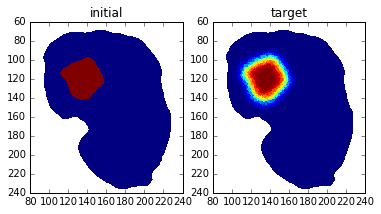

norm(k_opt) = 3.25086520609
J_opt = 0.140059396001
J_opt (without regularization) = 0.0330424689899


In [76]:
from __future__ import print_function
from dolfin import *
from dolfin_adjoint import *
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors

# Set log level
set_log_level(ERROR)

def make_artificial_obs(cd,xc,yc,R):
    '''
        Define the initial and target cellularity for testing purpose.
        Both are constant inside the tumor area.
        xc and yc are the coordinate of the center of the target tumor area 
        R is the radius of the target tumor area.
        The initial tumor is defined by the MeshFunction cd.
    '''
    initial_p = Function(V0,annotation=False)
    target_p = Function(V0,annotation=False)
    initial_p.rename('initial','initial tumor fraction')
    target_p.rename('target','target tumor fraction')
    p_values_i = [0,0.4]
    p_values_f = [0,0.9]

    for cell in cells(mesh):
        cell_no = V0.dofmap().cell_dofs(cell.index())
        # center of the cell
        xc_cell = np.average(cell.get_coordinate_dofs()[0::2])
        yc_cell = np.average(cell.get_coordinate_dofs()[1::2])

        # cd is a mesh function defined by the physical region xml file
        initial_p.vector()[cell_no] = p_values_i[int(cd.array()[cell_no]-1)]
        if(pow(xc_cell-xc,2.)+pow(yc_cell-yc,2.) < R*R):
            target_p.vector()[cell_no] = p_values_f[1]       
        else:
            target_p.vector()[cell_no] = p_values_f[0]                       
                
    return [initial_p,target_p]

def vis_obs(initial_p,target_p,label=0):
    '''
        Visualize the initial and target cellularity.
        When label >=0, the two distributions are saved to the global result file file_results
        with label=label.
    '''
    target_p = interpolate(target_p,V0)
    cm1 = colors.ListedColormap([[0,1,0,1],[0,0,0,1],[1,0,0,1]])    
    cm2 = cm.get_cmap('jet')
    plt.figure()
    plt.subplot(1,2,1)
    plt.title('initial')
    plot(initial_p,cmap=cm2)
    plt.gca().invert_yaxis()

    diff = Function(V0,annotation=False)
    diff.rename('diff','diff tumor fraction')
    diff.vector()[:] = initial_p.vector()-target_p.vector()
 
    plt.subplot(1,2,2)
    plt.title('target')
    plot(target_p,cmap=cm2)
    plt.gca().invert_yaxis()
    plt.show()
    
    if(label >= 0):
        file_results.write(initial_p, label)
        file_results.write(target_p, label)
        file_results.write(diff, label)

def forward(initial_p,annotate=False,record=False,record_initial=False,record_target=False):
    """ 
        Here, we define the forward problem. 
        See the attached pptx file for more information on the variables.
        Don't delete the necessary adjoint-dolfin argument: annotate.
    """
    def boundary(x, on_boundary):
        return on_boundary

    bc = DirichletBC(V, Constant(0.), boundary)

    # field of growth rate, treated as a local parameter here
    k.rename('k','k field')
    # current distribution of cell density (phi_T)
    p_n = Function(V, name = 'pn', annotate = annotate)
    p_n = interpolate(initial_p,V)
    p_n.rename('phi_T','tumor fraction')
    p = TrialFunction(V)
    q = TestFunction(V)
    # logistic source term
    S = p_n*(1-p_n/Theta)*k

    F = p*q*dx + D*dt*dot(grad(p), grad(q))*dx - (p_n + dt*S)*q*dx
    a, L = lhs(F), rhs(F)

    # Prepare the solution
    p = Function(V, name = 'p', annotate = annotate)

    t = 0.
    if record:
        # save the current solution, k field, initial and target solution
        file_results.write(p_n,t)
        file_results.write(k,t)
        if record_initial:
            file_results.write(initial_p,t)
        if record_target:
            file_results.write(target_p,t)

    for n in range(num_steps):
        # Update current time
        t += dt
        # Compute solution
        solve(a == L, p, annotate = annotate) # with trivial Neumann BC
        # Update previous solution
        p_n.assign(p, annotate = annotate)

        if record:
            file_results.write(p_n,t)
            file_results.write(k,t)
            if record_initial:
                file_results.write(initial_p,t)
            if record_target:
                file_results.write(target_p,t)
    return p

# Callback function for the optimizer
# Writes intermediate results to a logfile
def eval_cb(j, m):
    """ The callback function keeping a log """

    print("objective = %15.10e " % j)

def objective(p, target_p, r_coeff1, r_coeff2):
    return assemble(inner(p-target_p, p-target_p)*dx) + r_coeff1*assemble(k*k*dx) + r_coeff2*assemble(dot(grad(k),grad(k))*dx)

def optimize(dbg=False):
    """ The optimization routine """
    
    # Define the control
    m = [Control(k)]
    
    # Execute first time to annotate and record the tape
    p = forward(initial_p,True)

    J = objective(p, target_p, r_coeff1, r_coeff2)
    
    # Prepare the reduced functional
    rf = ReducedFunctional(J,m,eval_cb_post=eval_cb)
    # upper and lower bound for the parameter field
    k_lb = Function(V, annotate = False)
    k_ub = Function(V, annotate = False)
    k_lb.vector()[:] = 0
    k_ub.vector()[:] = 4

    # Run the optimization
    #m_opt = minimize(rf,method='L-BFGS-B', bounds = [k_lb,k_ub], tol=1.0e-6,options={"disp":True,"gtol":1.0e-6})
    
    m_opt = minimize(rf,method='L-BFGS-B', tol=1.0e-6,options={"disp":True,"gtol":1.0e-6})
    return m_opt


case = 0
r_coeff1 = 0.01
r_coeff2 = 0.01
inputs = ['placeholder', case, r_coeff1, r_coeff2]
output_dir = './output/validation'

output_dir = os.path.join(output_dir,'run'+str(case)) 
print('Regularization coefficient (order 0) = '+str(r_coeff1))
print('Regularization coefficient (order 1) = '+str(r_coeff2))
print('Output saved to '+output_dir)

# Prepare a mesh
mesh = Mesh("./gmsh_test.xml")
cd = MeshFunction('size_t',mesh,"./gmsh_test_physical_region.xml")
fd = MeshFunction('size_t',mesh,"./gmsh_test_facet_region.xml")
V0 = FunctionSpace(mesh, 'DG', 0)
V = FunctionSpace(mesh, 'CG', 1)

# Model parameters
T = 1.0             # final time
num_steps = 10       # number of time steps
dt = T / num_steps    # time step size
D = Constant(10.)      # mobility or diffusion coefficient
k_true = Function(V)    # true growth rate 
k_true.vector()[:] = 0.1 # initial distribution of the k field
k = Function(V)    # growth rate 
Theta = Constant(1.0) # carrying capacity

# Prepare output file
file_results = XDMFFile(os.path.join(output_dir,'optimal.xdmf'))
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True

# Optimization module
[initial_p, target_p] = make_artificial_obs(cd,135,135,50) # generate the initial and target cellularity
k = k_true
target_p = forward(initial_p,False,False,False,False) # run the forward model given the true k field
# ... note the previous target_p (generated by make_artificial_obs) is overwritten
target_p.rename('target','target tumor fraction')
vis_obs(initial_p,target_p,0) # visualize the initial and target cellularity

k.vector()[:] = 0.5 # initial guess of the k field
k = optimize() # optimize the k field using the adjoint method provided by adjoint_dolfin
model_p = forward(initial_p,False,True,True,True) # run the forward model using the optimized k field
print('norm(k_opt) = '+str(norm(k)))
print('J_opt = '+str(objective(model_p, target_p, r_coeff1, r_coeff2)))
print('J_opt (without regularization) = '+str(objective(model_p, target_p, 0., 0.)))



# Xinzeng's RD+LE

In [3]:
%matplotlib inline
from __future__ import print_function
from dolfin import *
from dolfin_adjoint import *
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors

# Set log level
set_log_level(ERROR)

def make_artificial_obs(cd,xc,yc,R):
    '''
        Define the initial and target cellularity for testing purpose.
        Both are constant inside the tumor area.
        xc and yc are the coordinate of the center of the target tumor area 
        R is the radius of the target tumor area.
        The initial tumor is defined by the MeshFunction cd.
    '''
    initial_p = Function(V0,annotation=False)
    target_p = Function(V0,annotation=False)
    initial_p.rename('initial','initial tumor fraction')
    target_p.rename('target','target tumor fraction')
    p_values_i = [0,0.4]
    p_values_f = [0,0.9]

    for cell in cells(mesh):
        cell_no = V0.dofmap().cell_dofs(cell.index())
        # center of the cell
        xc_cell = np.average(cell.get_coordinate_dofs()[0::2])
        yc_cell = np.average(cell.get_coordinate_dofs()[1::2])

        # cd is a mesh function defined by the physical region xml file
        initial_p.vector()[cell_no] = p_values_i[int(cd.array()[cell_no]-1)]
        if(pow(xc_cell-xc,2.)+pow(yc_cell-yc,2.) < R*R):
            target_p.vector()[cell_no] = p_values_f[1]       
        else:
            target_p.vector()[cell_no] = p_values_f[0]                       
                
    return [initial_p,target_p]

def vis_obs(initial_p,target_p,label=0):
    '''
        Visualize the initial and target cellularity.
        When label >=0, the two distributions are saved to the global result file file_results
        with label=label.
    '''
    target_p = interpolate(target_p,V0)
    cm1 = colors.ListedColormap([[0,1,0,1],[0,0,0,1],[1,0,0,1]])    
    cm2 = cm.get_cmap('jet')
    plt.figure()
    plt.subplot(1,2,1)
    plt.title('initial')
    plot(initial_p,cmap=cm2)
    plt.gca().invert_yaxis()

    diff = Function(V0,annotation=False)
    diff.rename('diff','diff tumor fraction')
    diff.vector()[:] = initial_p.vector()-target_p.vector()
 
    plt.subplot(1,2,2)
    plt.title('target')
    plot(target_p,cmap=cm2)
    plt.gca().invert_yaxis()
    plt.show()
    
    if(label >= 0):
        file_results.write(initial_p, label)
        file_results.write(target_p, label)
        file_results.write(diff, label)

def output(stress,t):
    stress_xx_proj = project(stress[0,0],V)
    stress_yy_proj = project(stress[1,1],V)
    stress_xy_proj = project(stress[0,1],V)
    stress_xx_proj.rename('sxx','xx component of Cauchy stress')
    stress_xx_proj.rename('syy','yy component of Cauchy stress')
    stress_xx_proj.rename('sxy','xy component of Cauchy stress')
    file_results.write(stress_xx_proj,t)
    file_results.write(stress_yy_proj,t)
    file_results.write(stress_xy_proj,t)

def forward(initial_p,annotate=False,record=False):
    """ 
        Here, we define the forward problem. 
        See the attached pptx file for more information on the variables.
        Don't delete the necessary adjoint-dolfin argument: annotate.
        list of parameters:
        p_n: phi_T solution of the previous step
        p: phi_T solution of the current step
        Theta: carrying capacity
        D: diffusion coefficient
        k: growth rate

        u: elastic displacement
        u_increm: incremental displacement with respect to the initial deformation
        mu: shear modulus
        nu: Poisson's ratio
        xi: mechanical effect of tumor invasion
    """
    def boundary(x, on_boundary):
        return on_boundary

    ############################ Reaction-diffusion part #####
    # field of growth rate, treated as a local parameter here
    k.rename('k','k field')
    # current distribution of cell density (phi_T)
    p_n = Function(V, annotate = annotate)
    p_n = interpolate(initial_p,V)
    p_n.rename('phi_T','tumor fraction')
    p = TrialFunction(V)
    q = TestFunction(V)
    # logistic source term
    S = p_n*(1-p_n/Theta)*k
    # (base) mobility or diffusion coefficient
    D0 = 10.      
    ############################ Elasticity part #####
    mu = 1000
    nu = 0.2
    xi = 1.0*mu
    #gamma = 1.0/mu # mechanical inhibition coefficient
    lambda_ = 2*mu*nu/(1-2*nu)
    u = TrialFunction(W)
    v = TestFunction(W)
    def epsilon(u):
        return (nabla_grad(u)+nabla_grad(u).T)/2.0
    def sigma(u):
        return lambda_*nabla_div(u)*Identity(dim)+2*mu*epsilon(u)
        
    bc_EL = DirichletBC(W, Constant((0.,0.)), boundary) # fixed Dirichelt boundary
    F_EL = inner(sigma(u),epsilon(v))*dx+inner(xi*grad(p_n),v)*dx # tumor-induced body force: -xi*grad(phi_T)
    a_EL, L_EL = lhs(F_EL), rhs(F_EL)
    u = Function(W, annotate = annotate)
    u.rename('disp','elastic displacement')
    u_initial = Function(W, annotate = annotate)
    u_initial.rename('disp (initial)','initial elastic displacement')
    u_increm = Function(W, annotate = annotate)
    u_increm.rename('disp (increm)','incremental elastic displacement')
    stress = lambda_*nabla_div(u)*Identity(dim)+2*mu*epsilon(u)
    strain = (nabla_grad(u)+nabla_grad(u).T)/2.0
    svm = sqrt((stress[0,0]**2.0 + stress[1,1]**2.0 - 
        stress[0,0]*stress[1,1]+3*stress[0,1]**2.0)/2.0)
    sxx = stress[0,0]
    syy = stress[1,1]
    sxy = stress[0,1]
 
    #D = D0 # without mechanical inhibition
    D = D0*exp(-gamma*svm) # with mechanical inhibition
    F_RD = p*q*dx + D*dt*dot(grad(p), grad(q))*dx - (p_n + dt*S)*q*dx
    a_RD, L_RD = lhs(F_RD), rhs(F_RD)
    p = Function(V, annotate = annotate)

    def solve_RD():
        solve(a_RD == L_RD, p, annotate = annotate) # with trivial Neumann BC
    def solve_EL():
        solve(a_EL == L_EL, u, bc_EL, annotate = annotate) # with fixed Dirichlet BC

    t = 0.
    solve_EL()
    u_initial.assign(u)
    u_increm.vector()[:] = 0
    if record:
        # save the current solution, k field, initial and target solution
        file_results.write(p_n,t)
        file_results.write(u_increm,t)
        file_results.write(u,t)
        file_results.write(k,t)
        sxx_proj = project(sxx,V)
        syy_proj = project(syy,V)
        sxy_proj = project(sxy,V)
        svm_proj = project(svm,V)
        sxx_proj.rename("sxx","normal Cauchy xx")
        syy_proj.rename("syy","normal Cauchy yy")
        sxy_proj.rename("sxy","shear Cauchy xy")
        svm_proj.rename("svm","von-mises Cauchy")
        file_results.write(sxx_proj,t)
        file_results.write(syy_proj,t)
        file_results.write(sxy_proj,t)
        file_results.write(svm_proj,t)
        D_proj = project(D,V)
        D_proj.rename("D","diffusion coefficient")
        file_results.write(D_proj,t)
        file_results.write(initial_p,t)

    for n in range(num_steps):
        # Update current time
        t += dt
        # Compute solution
        solve_RD()
        p_n.assign(p, annotate = annotate)
        solve_EL()
        u_increm.vector()[:] = u.vector()-u_initial.vector()
    
        if record:
            file_results.write(p_n,t)
            file_results.write(u_increm,t)
            file_results.write(u,t)
            file_results.write(k,t)
            sxx_proj = project(sxx,V)
            syy_proj = project(syy,V)
            sxy_proj = project(sxy,V)
            svm_proj = project(svm,V)
            sxx_proj.rename("sxx","normal Cauchy xx")
            syy_proj.rename("syy","normal Cauchy yy")
            sxy_proj.rename("sxy","shear Cauchy xy")
            svm_proj.rename("svm","von-mises Cauchy")
            file_results.write(sxx_proj,t)
            file_results.write(syy_proj,t)
            file_results.write(sxy_proj,t)
            file_results.write(svm_proj,t)
            D_proj = project(D,V)
            D_proj.rename("D","diffusion coefficient")
            file_results.write(D_proj,t)
 
            file_results.write(initial_p,t)

    return (p,u)

def function_deformed(p,u):
    V = p.function_space()
    mesh = V.mesh()
    mesh_deformed = Mesh(mesh) # make a copy of the original mesh which we will deform later
    
    '''
    # scale the actual displacement u
    u_mag = Function(u.function_space())
    u_mag.vector()[:] = u.vector()*10
    #ALE.move(mesh_deformed,u_mag)
    '''
    ALE.move(mesh_deformed,u)

    V_deformed = FunctionSpace(mesh_deformed, 'CG', 1)
    p_deformed = Function(V_deformed)
    p_deformed.vector()[:] = p.vector()

    '''
    plt.figure()
    plt.gca().invert_yaxis()
    plot(mesh)
    plt.figure()
    plt.gca().invert_yaxis()
    plot(mesh_deformed)

    plt.figure()
    plt.gca().invert_yaxis()
    plot(p)
    plt.figure()
    plt.gca().invert_yaxis()
    plot(p_deformed)

    plt.show()
    '''

    return p_deformed # p_deformed is the cellularity on the deformed configuration

# Callback function for the optimizer
# Writes intermediate results to a logfile
def eval_cb(j, m):
    """ The callback function keeping a log """

    print("objective = %15.10e " % j)

def objective(p, u, target_p, r_coeff1, r_coeff2):
    # this version of objective function works with the mechanically-coupled model (LE) 
    # which compares the cellularity in the undeformed configuration
    mesh = p.function_space().mesh()
    
    return assemble(inner(p-target_p, p-target_p)*dx(mesh)) + r_coeff1*assemble(k*k*dx(mesh)) + r_coeff2*assemble(dot(grad(k),grad(k))*dx(mesh))

def objective_debug(p, u, target_p, r_coeff1, r_coeff2):
    mesh = p.function_space().mesh()
    p_transformed = function_deformed(p,u)
    V_transformed = p_transformed.function_space()
    mesh_transformed = V_transformed.mesh()

    target_p_proj = interpolate(target_p, V_transformed)
 
    '''
    plt.figure()
    plot(p_transformed)
    plt.figure()
    plot(target_p_proj)
    plt.show()
    '''
   
    return assemble(inner(p_transformed-target_p_proj, p_transformed-target_p_proj)*dx(mesh_transformed)) + r_coeff1*assemble(k*k*dx(mesh)) + r_coeff2*assemble(dot(grad(k),grad(k))*dx(mesh))

def optimize(target_p, dbg=False):
    """ The optimization routine """
    
    # Define the control
    m = [Control(k), Control(gamma)]
    #m = Control(k)

    # Execute first time to annotate and record the tape
    [p,u] = forward(initial_p,True,False)

    J = objective(p, u, target_p, r_coeff1, r_coeff2)
    
    # Prepare the reduced functional
    rf = ReducedFunctional(J,m,eval_cb_post=eval_cb)
    # upper and lower bound for the parameter field
    k_lb = Function(V, annotate = False)
    k_ub = Function(V, annotate = False)
    k_lb.vector()[:] = 0
    k_ub.vector()[:] = 4

    # Run the optimization
    #m_opt = minimize(rf,method='L-BFGS-B', bounds = [k_lb,k_ub], tol=1.0e-6,options={"disp":True,"gtol":1.0e-6})
    
    m_opt = minimize(rf,method='L-BFGS-B', tol=1.0e-6,options={"disp":True,"gtol":1.0e-6})

    target_p.rename("target","target cellularity for optimization")
    file_target << target_p
    return m_opt


case = 0
r_coeff1 = 0.1
r_coeff2 = 0
base_dir = './Output/CaseX_validation'

output_dir = os.path.join(base_dir,'run'+str(case)) 
print('Regularization coefficient (order 0) = '+str(r_coeff1))
print('Regularization coefficient (order 1) = '+str(r_coeff2))
print('Output saved to '+output_dir)

# Prepare a mesh
mesh = Mesh("./gmsh_test.xml")
dim = 2
cd = MeshFunction('size_t',mesh,"./gmsh_test_physical_region.xml")
fd = MeshFunction('size_t',mesh,"./gmsh_test_facet_region.xml")
V0 = FunctionSpace(mesh, 'DG', 0) # for defining the test initial and target cellularity
V = FunctionSpace(mesh, 'CG', 1) # for defining ordinary variables
W = VectorFunctionSpace(mesh, 'Lagrange', 1) # for defining elastic displacement
Area = assemble(Constant(1.0)*dx(mesh)) # total area of the kidney

# Model parameters
T = 10.0             # final time
num_steps = 10       # number of time steps
dt = T / num_steps    # time step size
k_true = Function(V)    # true growth rate 
k_true.vector()[:] = 0.2 # initial distribution of the k field
k = Function(V)    # growth rate 
Theta = Constant(1.0) # carrying capacity
gamma = Constant(0.001)

# Prepare output file
file_results = XDMFFile(os.path.join(output_dir,'optimal.xdmf'))
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True
file_target = File(os.path.join(output_dir,'target.pvd'))

# Optimization module
[initial_p,target_p] = make_artificial_obs(cd,135,135,50) # generate the initial and target cellularity
k.vector()[:] = k_true.vector()
(target_p,target_u) = forward(initial_p,False,False) # run the forward model given the true k field
# ... note the previous target_p (generated by make_artificial_obs) is overwritten
target_p_transformed = function_deformed(target_p,target_u)
target_p_transformed.rename('target','target tumor fraction (transformed)')

#vis_obs(initial_p,target_p,0) # visualize the initial and target cellularity

k.vector()[:] = 0.8 # initial guess of the k field
[k,gamma] = optimize(target_p) # optimize the k field using the adjoint method provided by adjoint_dolfin
#k = optimize(target_p) # optimize the k field using the adjoint method provided by adjoint_dolfin
(model_p,model_u) = forward(initial_p,False,True) # run the forward model with the optimized k field
print('mean(k_true) = '+str(norm(k_true)/sqrt(Area)))
print('mean(k_opt) = '+str(norm(k)/sqrt(Area)))
print('J_opt = '+str(objective(model_p, model_u, target_p, r_coeff1, r_coeff2)))
print('J_opt (without regularization) = '+str(objective(model_p, model_u, target_p, 0., 0.)))



Regularization coefficient (order 0) = 0.1
Regularization coefficient (order 1) = 0
Output saved to ./Output/CaseX_validation/run0
Calling FFC just-in-time (JIT) compiler, this may take some time.


/home/xoab/anaconda2/lib/python2.7/site-packages/ffc/uflacs/analysis/dependencies.py:63: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  active[targets] = 1


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FF

Output saved to ./output/rat05
Regularization coefficient (order 0) = 0.01
Regularization coefficient (order 1) = 0.01


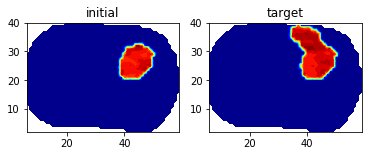

Calling FFC just-in-time (JIT) compiler, this may take some time.


/home/xoab/anaconda2/lib/python2.7/site-packages/ffc/uflacs/analysis/dependencies.py:63: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  active[targets] = 1


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
norm(k_opt) = 6.71081084325
J_opt = 103.869576424
J_opt (without regularization) = 101.915531116


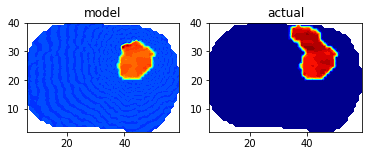

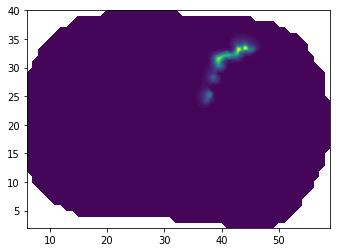

In [4]:
%matplotlib inline
from __future__ import print_function
from dolfin import *
from dolfin_adjoint import *
import numpy as np
import os, sys
import scipy.io as scio
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors

# Set log level
set_log_level(WARNING)

class InterpolatedParameter(Expression):
    def __init__(self,X,Y,image,**kwargs):
        self.X = X # A numpy array giving the X-spacing of the image
        self.Y = Y # Same for Y
        self.image = image # The image of measured material property    
    def eval_cell(self,values,x,cell):
        interp_handle = RegularGridInterpolator((self.X,self.Y),self.image)
        values[0] = interp_handle(x)
        
def interp(file_location,mat_name):
    mat = scio.loadmat(file_location)[mat_name]
    mat = np.fliplr(mat.T)/Theta               # Needs to be adjusted to fit the mesh correctly
    x,y = mat.shape[0], mat.shape[1]
    func = InterpolatedParameter(np.linspace(1,x,x),np.linspace(1,y,y),mat,degree=1)
    func = interpolate(func,V)    
    return func

def vis_obs(initial_p,target_p,title1,title2):
    '''
        Compare two quantity plots, for example initial vs. target cellularity
        Accepts titles for each plot
    '''
    target_p = interpolate(target_p,V)
    cm1 = colors.ListedColormap([[0,1,0,1],[0,0,0,1],[1,0,0,1]])    
    cm2 = cm.get_cmap('jet')
    plt.figure()
    plt.subplot(1,2,1)
    plt.title(title1)
    plot(initial_p,cmap=cm2)
 
    plt.subplot(1,2,2)
    plt.title(title2)
    plot(target_p,cmap=cm2)
    plt.show()

def forward(initial_p,annotate=False,record=False,record_initial=False,record_target=False):
    """ 
        Here, we define the forward problem. 
        See the attached pptx file for more information on the variables.
        Don't delete the necessary adjoint-dolfin argument: annotate.
    """
    global D
    
    def boundary(x, on_boundary):
        return on_boundary

    bc = DirichletBC(U, Constant((0.,0.)), boundary)

    def E(u):
        return 0.5*(nabla_grad(u) + nabla_grad(u).T)
    def sigma(u,phi):
        return 2*mu*(E(u)-beta*phi*Identity(2))+lam*(tr(E(u))-2*beta*phi)*Identity(2)
    def vonmises(u, phi):
        s = sigma(u, phi) - (1./3)*tr(sigma(u, phi))*Identity(2)  # deviatoric stress
        von_Mises = sqrt(3./2*inner(s, s))
        return project(von_Mises, V)
    def le(phi):
        u = TrialFunction(U)
        v = TestFunction(U)
        F = -inner(sigma(u, phi), E(v))*dx 
        a, L = lhs(F), rhs(F)
        u = Function(U, name = 'u', annotate = annotate)
        solve(a == L, u, bc, annotate = annotate)
        return u
    
    # field of growth rate, treated as a local parameter here
    k.rename('k','k field')
    # current distribution of cell density (phi_T)
    p_n = Function(V, name = 'pn', annotate = annotate)
    p_n = interpolate(initial_p,V)
    p_n.rename('phi_T','tumor fraction')
    p = TrialFunction(V)
    q = TestFunction(V)
    
    # logistic source term
    mu = 10
    nu = 0.2
    beta = .10*mu
    lam = 2*mu*nu/(1-2*nu)
    disp = le(p_n)
    vm = vonmises(disp,p_n)
    D = D0*exp(-gammaD*vm)
    
    S = p_n*(1-p_n)*k
    F = p*q*dx + D*dt*dot(grad(p), grad(q))*dx - (p_n + dt*S)*q*dx
    a, L = lhs(F), rhs(F)

    # Prepare the solution
    p = Function(V, name = 'p', annotate = annotate)

    t = 0.
    if record:
        # save the current solution, k field, initial and target solution
        file_results.write(p_n,t)
        file_results.write(k,t)
        if record_initial:
            file_results.write(initial_p,t)
        if record_target:
            file_results.write(target_p,t)

    for n in range(num_steps):
        # Update current time
        disp = le(p_n)
        vm = vonmises(disp,p_n)
        D = D0*exp(-gammaD*vm)
        
        t += dt
        # Compute solution
        solve(a == L, p, annotate = annotate) # with trivial Neumann BC
        # Update previous solution
        p_n.assign(p, annotate = annotate)

        if record:
            file_results.write(p_n,t)
            file_results.write(k,t)
            if record_initial:
                file_results.write(initial_p,t)
            if record_target:
                file_results.write(target_p,t)
    return p

# Callback function for the optimizer
# Writes intermediate results to a logfile
def eval_cb(j, m):
    """ The callback function keeping a log """

    print("objective = %15.10e " % j)

def objective(p, target_p, r_coeff1, r_coeff2):
    return assemble(10*inner(p-target_p, p-target_p)*dx) + \
        r_coeff1*assemble(k*k*dx) + r_coeff2*assemble(dot(grad(k),grad(k))*dx)

def optimize(dbg=False):
    """ The optimization routine """
    
    # Define the control
    m = [Control(k), Control(D0)]

    # Execute first time to annotate and record the tape
    p = forward(initial_p,True)

    J = objective(p, target_p, r_coeff1, r_coeff2)

    # Prepare the reduced functional
    rf = ReducedFunctional(J,m,eval_cb_post=eval_cb)
    # upper and lower bound for the parameter field
    k_lb = Function(V, annotate = False)
    k_ub = Function(V, annotate = False)
    k_lb.vector()[:] = 0
    k_ub.vector()[:] = 4
    D_lb = 0
    D_ub = 10

    # Run the optimization
    m_opt = minimize(rf,method='L-BFGS-B', bounds = [(k_lb, D_lb),(k_ub, D_ub)], tol=1.0e-6,options={"disp":True,"gtol":1.0e-6})
    
    #m_opt = minimize(rf,method='L-BFGS-B', tol=1.0e-6,options={"disp":True,"gtol":1.0e-6})
    return m_opt


#########################################################################
# MAIN CODE
#########################################################################

case = 0
r_coeff1 = 0.01
r_coeff2 = 0.01
inputs = ['placeholder', case, r_coeff1, r_coeff2]

output_dir = os.path.join('./output/rat05') 
print('Output saved to '+output_dir)
print('Regularization coefficient (order 0) = '+str(r_coeff1))
print('Regularization coefficient (order 1) = '+str(r_coeff2))

# Prepare a mesh
mesh = Mesh("../../rat-data/rat05/gmsh.xml")
V = FunctionSpace(mesh, 'CG', 1)
U = VectorFunctionSpace(mesh,'Lagrange',1)

# Model parameters
T = 2.            # final time
num_steps = 20       # number of time steps
dt = T / num_steps    # time step size
Theta = 59070 # carrying capacity
    
# Load initial tumor condition data
initial_p = interp("../../rat-data/rat05/ic.mat",'ic')
target_p = interp("../../rat-data/rat05/tumor_t2.mat",'tumor')
initial_p.rename('initial','tumor at day 0')
target_p.rename('target','tumor at day 2')

# Parameters to be optimized
gammaD = Constant(2.)     # initial guess of gamma_D
k = Function(V)    # growth rate 
k.vector()[:] = 0.5 # initial guess of the k field
D0 = Constant(1.0)

# Prepare output file
file_results = XDMFFile(os.path.join(output_dir,'optimal.xdmf'))
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True

vis_obs(initial_p,target_p,'initial','target') # visualize the initial and target cellularity

# Optimization module
[k, D0] = optimize() # optimize the k field using the adjoint method provided by adjoint_dolfin
model_p = forward(initial_p,False,True,True,True) # run the forward model using the optimized k field
print('norm(k_opt) = '+str(norm(k)))
print('J_opt = '+str(objective(model_p, target_p, r_coeff1, r_coeff2)))
print('J_opt (without regularization) = '+str(objective(model_p, target_p, 0., 0.)))
vis_obs(model_p,target_p,'model','actual')
plot(k)